In [1]:
import cupy as np
import matplotlib.pyplot as plt
import pathlib,sys,os,json
from cupy.fft import rfft2,irfft2
from matplotlib.colors import TwoSlopeNorm
import matplotlib as mpl
mpl.rc("text", usetex = True)

In [11]:
paramfile = '/home/rajarshi.chattopadhyay/fluid/2DV_and_particles/parameters.json'
with open(paramfile,'r') as jsonFile: params = json.load(jsonFile)

d = params["d"] # Dimension
nu =params["nu"] # Viscosity
Re = 1/nu if nu > 0 else np.inf # Reynolds number
N = Nx = Ny = params["N"] # Grid size
dt = params["dt"] # Timestep
T = params["T"] # Final time
alph = params["alph"] # Density of the particles
eta = params["eta"]/(Nx//3) # Desired Kolmogorov length scale
Nprtcl = params["Nprtcl"] # Number of particles

In [10]:
savePlot = pathlib.Path(f"/home/rajarshi.chattopadhyay/fluid/2DV_and_particles/Plots/Re_{np.round(Re,2)},dt_{dt},N_{N}/")
savePlot.mkdir(parents=True, exist_ok=True)
loadPath = pathlib.Path(f"/home/rajarshi.chattopadhyay/fluid/2DV_and_particles/data/Re_{np.round(Re,2)},dt_{dt},N_{N}/")
loadPath.exists()

False

In [7]:
Lx, Ly = (2*np.pi),(2*np.pi) #Length of the grid
X,Y = np.linspace(0,Lx,Nx,endpoint= False), np.linspace(0,Ly,Ny,endpoint= False)
dx = X[1] - X[0]
dy = Y[1] - Y[0]
x,y = np.meshgrid(X,Y,indexing="ij")

## It is best to define the function which returns the real part of the iifted function as ifft. 
ifft2 = lambda x: irfft2(x,(Nx,Ny))

## Forming the 2D grid (k space)
Kx = 2*np.pi*np.linspace(-(Nx//2) , Nx//2 - 0.5*(1+ (-1)**(Nx%2)),Nx)/Lx
Ky = 2*np.pi*np.linspace(-(Ny//2) , Ny//2 - 0.5*(1+ (-1)**(Ny%2)),Ny)/Ly
Kx = np.append(Kx[Kx>=0], Kx[Kx<0])
Ky = np.append(Ky[Ky>=0], -Ky[0])
kx,ky = np.meshgrid(Kx,Ky,indexing="ij")
## Defining the inverese laplacian.
lap = -(kx**2 + ky**2)
# lap1 = lap.copy()
# lap1[lap1== 0] = np.inf
lapinv = 1.0/np.where(lap == 0., np.inf, lap)

In [7]:
xi_last = np.load(loadPath/f"last/w.npy")
xi_last_r = ifft2(xi_last)
print(xi_last_r.max())
Xplot,Yplot = np.linspace(0,Lx,Nx+1,endpoint= True), np.linspace(0,Ly,Ny+1,endpoint= True)
xnew = np.zeros((Nx+1,Ny+1))
xnew[1:,1:] = np.roll(xi_last_r, -1,axis = (0,1))
xnew[:-1,:-1] = xi_last_r    

1.3573753054584434


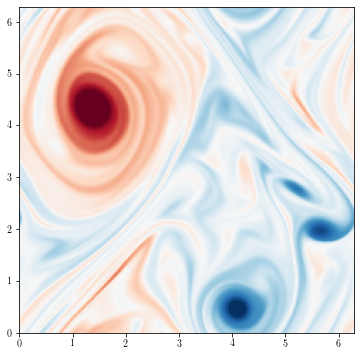

In [8]:
plt.figure(figsize=(6,6))
norm = TwoSlopeNorm(vcenter = 0,vmax = 0.2*5,vmin=-0.2*5)
p1 = plt.pcolor(Xplot.get(),Yplot.get(),(xnew.T).get(),cmap = "RdBu_r",norm = norm)
# plt.colorbar(p1)
plt.show()
plt.close()

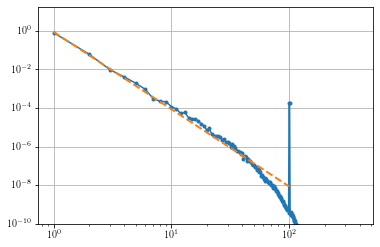

0.3138368200843354 1.0140909683319097 0.0005076474569393057


In [10]:
e_arr = np.load(loadPath/f"last/e_arr.npy")
kplot = np.arange(e_arr.size)
dissip = np.sum(2*nu*kplot**2*e_arr)
eta = (nu**3/dissip)**0.25
t_k = eta**2/nu
plt.plot(kplot[1:].get(),(e_arr[1:]*kplot[1:]**(0/3)).get(),'.-')
# plt.axvline(Nx//3*0.5,color = "black")
# plt.axvline(Nx//3*0.6,color = "black")
# plt.axvline(2,color = "black")
# plt.axvline(4,color = "black")
xline1 = np.array([1.,100.])
yline1 = xline1**(-12/3)
yline1[:] = yline1/yline1[0]*e_arr[1]*1.1
plt.plot(xline1.get(),yline1.get(),"--",linewidth = 2)
plt.xscale("log")
plt.yscale("log")
plt.ylim(1e-10,plt.ylim()[-1])
# plt.xlim(120,180)
plt.grid()
np.sum(e_arr)
plt.show()
print(t_k,eta*(N//3),dissip)

In [141]:
((5e-5**3/0.005)**0.25)*(512)

1.1448668044798924

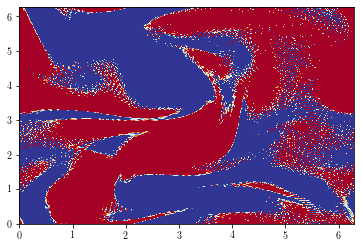

In [61]:
norm = TwoSlopeNorm(vcenter = 0,vmax = 0.1,vmin=-0.1)
plt.pcolor(Xplot.get(),Yplot.get(),(xnew.T).get(),cmap = "RdYlBu",norm = norm)
# plt.plot(pos[:,0].get(),pos[:,1].get(),'.',color='black',markersize  = 0.3)

PiYG
PRGn
BrBG
mor
RdGy
RdBu
RdYlBu
RdYlGn
Spectral
coolwarm
bwr
seismic

FileNotFoundError: [Errno 2] No such file or directory: '/home/rajarshi.chattopadhyay/fluid/caustics/Plots/Re_20000.0,dt_0.002,N_768/alpha_1.0_time_5.00.png'

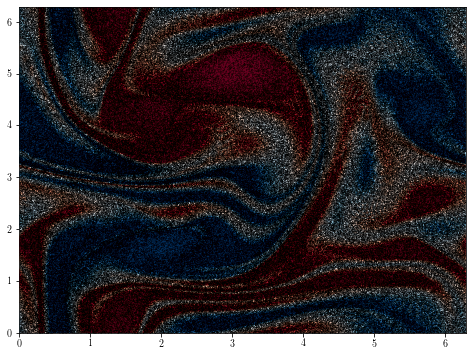

In [20]:
Xplot,Yplot = np.linspace(0,Lx,Nx+1,endpoint= True), np.linspace(0,Ly,Ny+1,endpoint= True)
xnew = np.zeros((Nx+1,Ny+1))
plt.figure(figsize = (8,6))
plt.xlabel(r"$x$")
plt.ylabel(r"$y$", rotation = 0)
for t in np.arange(0,40.1,1):
    print(t,end = '\r')
    pos= np.load(loadPath/f"alpha_{alph:.2}_prtcl/time_{t:.2f}/pos.npy")
    if abs(int(t) - t) < 0.01:
        xi_last = np.load(loadPath/f"time_{t:.2f}/w.npy")
        xi_last_r = ifft2(xi_last)
        xnew[1:,1:] = np.roll(xi_last_r, -1,axis = (0,1))
        xnew[:-1,:-1] = xi_last_r
    norm = TwoSlopeNorm(vcenter = 0,vmax = 1.,vmin=-1.)
    p1 = plt.pcolor(Xplot.get(),Yplot.get(),(xnew.T).get(),cmap = "RdBu_r",norm = norm,alpha=0.6)
    # plt.colorbar()
    plt.plot(pos[:,0].get(),pos[:,1].get(),'.',color='#000000',markersize  = 0.2)
    plt.savefig(savePlot/f"alpha_{alph:.2}_time_{t:.2f}.png",dpi = 200)
    plt.clf()

         